# Purpose
This notebook is meant to help us figure out the difference of subreddits between v0.3.2 and v0.3.1. 

It's possible that v0.3.2 added some new subreddits that are relevant but dropped some that were interesting.

In [1]:
%load_ext google.colab.data_table

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# colab auth for BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
# Attach google drive & import my python utility functions
from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

from eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    style_df_numeric,
)

Mounted at /content/gdrive


In [7]:
# Regular Imports
from google.cloud import bigquery

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted

In [8]:
# !pip list

# Pull data
top subreddits that are geo-relevant to Germany

## Pull v0.3.1

In [9]:
client = bigquery.Client(project='data-prod-165221')

In [33]:
%%time
sql_v31 = """
SELECT
  sub.subreddit_name AS subreddit_name
  , sub.combined_topic_and_rating
  , sub.rating
  , sub.topic
  , sub.over_18

  , asr.users_l28
  , asr.posts_l28
  , asr.comments_l28
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_cluster_labels_v031_a` AS sub
LEFT JOIN (
    SELECT * FROM `data-prod-165221.all_reddit.all_reddit_subreddits`
    WHERE DATE(pt) = (CURRENT_DATE() - 2)
) AS asr
  ON sub.subreddit_name = asr.subreddit_name
"""
df_v31 = (
    client.query(sql_v31)
    .to_dataframe()
)
print(df_v31.shape)

(628, 8)
CPU times: user 45.6 ms, sys: 1.21 ms, total: 46.8 ms
Wall time: 3.27 s


In [34]:
%%time
sql_v32 = """
SELECT
  sub.subreddit_name AS subreddit_name
  , sub.combined_topic_and_rating
  , sub.rating
  , sub.topic
  , sub.over_18

  , asr.users_l28
  , asr.posts_l28
  , asr.comments_l28
  
FROM `reddit-employee-datasets.david_bermejo.subclu_subreddit_cluster_labels_v032_a` sub
LEFT JOIN (
    SELECT * FROM `data-prod-165221.all_reddit.all_reddit_subreddits`
    WHERE DATE(pt) = (CURRENT_DATE() - 2)
) AS asr
  ON sub.subreddit_name = asr.subreddit_name
"""
df_v32 = (
    client.query(sql_v32)
    .to_dataframe()
)
print(df_v32.shape)

(3767, 8)
CPU times: user 111 ms, sys: 3.2 ms, total: 114 ms
Wall time: 3.47 s


## Check diff between v0.3.1 and v0.3.2

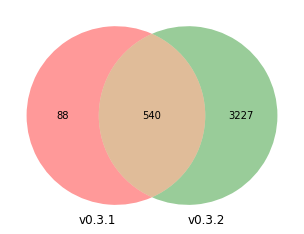

In [35]:
ax = venn2_unweighted(
    [set(df_v31['subreddit_name']), set(df_v32['subreddit_name'])],
    set_labels=('v0.3.1', 'v0.3.2')
)

# ax.set_title("Overlap between v0.3.1 and v0.3.2")

In [36]:
set_in_v31_but_not_v32 = (
    set(df_v31['subreddit_name']) - set(df_v32['subreddit_name'])
)
set_in_both_v31_and_v32 = (
    set(df_v31['subreddit_name']) & set(df_v32['subreddit_name'])
)
set_in_v32_but_not_v31 = (
    set(df_v32['subreddit_name']) - set(df_v31['subreddit_name'])
)

### Subs missing from new data

Looks like most of these simply don't have enough posts.

But there are like ~15 subs that have more than 8 posts... not sure if they were dormant when I pulled the data.

In [38]:
(
    df_v31[df_v31['subreddit_name'].isin(set_in_v31_but_not_v32)]
    .sort_values(by=['posts_l28', 'users_l28', 'comments_l28'], ascending=False)
    .reset_index(drop=True)
)

,subreddit_name,combined_topic_and_rating,rating,topic,over_18,users_l28,posts_l28,comments_l28
0,rainbowsixde,gaming,None,None,None,770,36,284
1,metallmaimais,uncategorized,None,None,None,849,33,170
2,zeldade,gaming,None,None,None,472,17,91
3,leakoeln50667,uncategorized,None,None,None,3520,16,11
4,studium,uncategorized,None,None,None,507,15,44
...,...,...,...,...,...,...,...,...
83,kulturdigital,culture + entertainment,None,None,None,2,0,0
84,germannoir,over18_nsfw,None,None,t,2,0,0
85,mediende,culture + entertainment,None,None,None,2,0,0
86,rustde,gaming,None,None,None,0,0,0


In [42]:
# these are the subs that have fewer than 4 posts
df_v31[(
    (df_v31['subreddit_name'].isin(set_in_v31_but_not_v32)) &
    (df_v31['posts_l28'] < 4)
)].shape

(61, 8)

# Add new column to check more DE & ambassador subreddits

It's likely there are more than 540 German-relevant subs that we want to tag.

## Load ambassador & DE-relevant subreddits

In [43]:
%%time
sql_ambassador_subs = """
SELECT 
  LOWER(subreddit_name) AS subreddit_name
  , subreddit_info
  , topic
FROM `reddit-employee-datasets.wacy_su.ambassador_subreddits` 
"""
df_ambassador_subs = (
    client.query(sql_ambassador_subs)
    .to_dataframe()
)
print(df_ambassador_subs.shape)

(171, 3)
CPU times: user 49.1 ms, sys: 4.87 ms, total: 54 ms
Wall time: 2.68 s


In [45]:
# make sure there's nothing weird with stripping out spaces from subreddit name
assert set(df_ambassador_subs['subreddit_name']) == set(df_ambassador_subs['subreddit_name'].str.strip())

True

In [44]:
%%time
sql_de_subs = """
SELECT 
  *
FROM `reddit-employee-datasets.wacy_su.geo_relevant_subreddits_2021`
  WHERE geo_country_code = "DE"
"""
df_de_subs = (
    client.query(sql_de_subs)
    .to_dataframe()
)
print(df_de_subs.shape)

(987, 6)
CPU times: user 35.9 ms, sys: 915 µs, total: 36.8 ms
Wall time: 948 ms


## Join with v.3.2 data to check how many are DE/Ambassador subs

In [47]:
set_subs_de_or_ambassador = (
    set(df_ambassador_subs['subreddit_name']) |
    set(df_de_subs['subreddit_name'])
)
len(set_subs_de_or_ambassador)

1153

In [48]:
df_v32.head()

,subreddit_name,combined_topic_and_rating,rating,topic,over_18,users_l28,posts_l28,comments_l28
0,artistic_nudity,uncategorized,None,None,f,3539,59,80
1,katjaglieson,uncategorized,None,None,None,1651,7,2
2,workoutgirls,uncategorized,None,None,f,45376,389,1082
3,anime_titties,world news,r,World News,f,171499,577,15603
4,cursedcursedcomments,uncategorized,r,None,f,22760,59,552


In [49]:
df_v32['geo_relevant_de_or_ambassador'] = np.where(
    df_v32['subreddit_name'].isin(set_subs_de_or_ambassador),
    'DE or Ambassador',
    'Not DE'
) 

In [50]:
value_counts_and_pcts(df_v32['geo_relevant_de_or_ambassador'])

,geo_relevant_de_or_ambassador-count,geo_relevant_de_or_ambassador-percent,geo_relevant_de_or_ambassador-pct_cumulative_sum
Not DE,"3,180",84.4%,84.4%
DE or Ambassador,587,15.6%,100.0%


### Get the names/info for the 47 subreddits that are German relevant and not in v0.3.1

In [58]:
set_subs_de_in_v32 = set(df_v32[df_v32['geo_relevant_de_or_ambassador'] == 'DE or Ambassador']['subreddit_name'])

set_subs_de_and_new_in_v32 = (
    set_subs_de_in_v32 -
    set_in_both_v31_and_v32
)
len(set_subs_de_and_new_in_v32)

57

In [59]:
len(set_subs_de_in_v32)

587

In [57]:
len(set_in_both_v31_and_v32)

540

Looks like some subs in the previous score where not DE relevant... maybe they were relevant to Austria or Switzerland!

In [64]:
set_in_both_v31_and_v32.issubset(set_subs_de_in_v32)

False

In [65]:
set_in_both_v31_and_v32 - set_subs_de_in_v32

{'aeiou',
 'askswitzerland',
 'austria',
 'buenzli',
 'ethz',
 'graz',
 'okoidawappler',
 'switzerland',
 'wien',
 'zurich'}

In [61]:
len(
    set_subs_de_in_v32 -
    set_in_both_v31_and_v32
)

57

In [63]:
df_v32[df_v32['subreddit_name'].isin(set_subs_de_and_new_in_v32)].shape

(57, 9)

In [69]:
(
    df_v32[df_v32['subreddit_name'].isin(set_subs_de_and_new_in_v32)]
    .sort_values(by=['users_l28', 'posts_l28'], ascending=False)
    .reset_index(drop=True)
)

,subreddit_name,combined_topic_and_rating,rating,topic,over_18,users_l28,posts_l28,comments_l28,geo_relevant_de_or_ambassador
0,reved,uncategorized,None,None,f,26273,753,310,DE or Ambassador
1,elisaaline,over18_nsfw,None,None,t,17378,30,43,DE or Ambassador
2,suziegrime,over18_nsfw,None,None,t,13264,1,13,DE or Ambassador
3,kellymissesvlogof,over18_nsfw,nc17,Mature Themes and Adult Content,None,13028,5,0,DE or Ambassador
4,juliabeautxtributs,uncategorized,None,None,f,12308,58,59,DE or Ambassador
5,sophstardustasmrfap,uncategorized,None,None,None,6426,12,52,DE or Ambassador
6,justlucyofficial,uncategorized,None,None,None,6069,9,4,DE or Ambassador
7,kickbasemanager,uncategorized,None,None,f,4098,64,262,DE or Ambassador
8,american_football,uncategorized,None,None,None,3965,122,216,DE or Ambassador
9,reveddit,uncategorized,None,None,None,2666,6,18,DE or Ambassador


In [71]:
import os
os.getcwd()

'/content'

### Save only the new subs

In [74]:
(
    df_v32[df_v32['subreddit_name'].isin(set_subs_de_and_new_in_v32)]
    .sort_values(by=['users_l28', 'posts_l28'], ascending=False)
    .reset_index(drop=True)
    .to_csv("/content/gdrive/MyDrive/Colab Notebooks/data/new_DE_subreddits_in_v0.3.2_to_tag.csv")
)

### Create new column for whether subreddit was in v31 and v32

In [75]:
df_v32.loc[df_v32['subreddit_name'].isin(set_subs_de_or_ambassador)
           , 'subreddit_in_v31_or_v32'] = 'in v0.3.2'

df_v32.loc[df_v32['subreddit_name'].isin(set_in_both_v31_and_v32)
           , 'subreddit_in_v31_or_v32'] = 'in both v0.3.1 & v0.3.2'


In [77]:
value_counts_and_pcts(
    df_v32[df_v32['subreddit_name'].isin(set_subs_de_or_ambassador)]
    ['subreddit_in_v31_or_v32']
)

,subreddit_in_v31_or_v32-count,subreddit_in_v31_or_v32-percent,subreddit_in_v31_or_v32-pct_cumulative_sum
in both v0.3.1 & v0.3.2,530,90.3%,90.3%
in v0.3.2,57,9.7%,100.0%


## Save all the subs to rate, include user counts & flag for whether sub was included in v31 or v32

In [80]:
(
    df_v32[df_v32['subreddit_name'].isin(set_subs_de_or_ambassador)]
    .sort_values(by=['users_l28', 'posts_l28'], ascending=False)
    .reset_index(drop=True)
    .to_csv("/content/gdrive/MyDrive/Colab Notebooks/data/All_DE_subreddits_in_v0.3.2_to_tag.csv")
)